In [1]:
import numpy as np
import pandas as pd
import six
import tensorflow as tf
import time
import os
from tqdm import tqdm

import random
import string

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import keras

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_PATH = 'data/outputs/name_price_desc.csv'
df_wines = pd.read_csv(DATA_PATH, sep='|', low_memory=False)

# Clean pricing data
df_wines['price'] =  df_wines['price'].str.strip('[]')
df_wines = df_wines[df_wines['price'] != '']
df_wines = df_wines[~df_wines['price'].str.contains(' ')]
df_wines['price'] = df_wines['price'].astype(float)

print(df_wines.shape)
df_wines.head()

(15191, 3)


,name,price,description
0,Hall Napa Valley Cabernet Sauvignon 2013,54.99,"Dark garnet in color, the 2013 HALL Napa Valle..."
1,Rombauer Chardonnay 2017,36.99,Rombauer Vineyards was founded in 1982 by Koer...
2,Antinori Tignanello 2015,124.99,#24
3,Borne of Fire Cabernet Sauvignon 2016,19.99,"Like a phoenix rising from the ashes, we have ..."
4,Torbreck Woodcutters Shiraz 2017,21.99,This wine reflects the up and coming Shiraz vi...


In [98]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# define 5 documents
docs = df_wines['description'].astype(str)
# create the tokenizer
NUM_WORDS = 2000
t = Tokenizer(num_words=NUM_WORDS)
# fit the tokenizer on the documents
t.fit_on_texts(docs)
	
encoded_matrix = t.texts_to_matrix(texts=docs, mode='count')
print(encoded_matrix.shape)
encoded_matrix[:50,:50]

encoded_seq = t.texts_to_sequences(docs)
print("Total length: ", len(encoded_seq))
print("Lrngth of first sequence: ", len(encoded_seq[0]))
print("Sample: ", encoded_seq[0][:10])
print("Max value: ",np.max(encoded_seq))

# pad sequences
max_length = max([len(s) for s in encoded_seq])
X = pad_sequences(encoded_seq, maxlen=max_length, padding='post')
y = df_wines['price']

print(max_length)
print("X: ",X.shape)
print("y: ",y.shape)

(15191, 2000)
Total length:  15191
Lrngth of first sequence:  49
Sample:  [48, 276, 6, 33, 1, 486, 98, 45, 42, 50]
Max value:  [1982, 783, 34, 7, 1719, 11, 1, 3, 1, 188, 375, 1, 685, 7, 44, 874, 2, 379, 1370, 14, 1, 1485, 1212, 1982, 783, 34, 7, 1, 1917, 134, 24, 8, 90, 1267, 5, 686, 240, 3, 10, 1814, 34, 114, 11, 229, 507, 345, 25, 13, 94, 1409, 2, 289, 105, 2]
297
X:  (15191, 297)
y:  (15191,)


In [84]:
from sklearn.model_selection import train_test_split

X_train,\
X_test,\
y_train,\
y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [85]:
# define vocabulary size (largest integer value)
vocab_size = len(t.word_index) + 1
print(vocab_size)

21426


In [87]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

acc_metric = 'mean_squared_error'

# define model
model = Sequential()
model.add(Embedding(vocab_size, NUM_WORDS, input_length=max_length))
model.add(Conv1D(filters=16, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))
print(model.summary())

d_model = Sequential()
d_model.add(Embedding(vocab_size, 250, input_length=max_length))
d_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
d_model.add(Dense(64, kernel_initializer='normal',activation='relu'))
d_model.add(Dense(32, kernel_initializer='normal',activation='relu'))
d_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

checkpoint = ModelCheckpoint('data/models_weights/model_price.h5', 
                             monitor=acc_metric, 
                             verbose=0, 
                             save_best_only=True, 
                             mode='min')
early_stopping = EarlyStopping(monitor=acc_metric,
                               patience=3,
                               mode='min')
tboard = keras.callbacks.TensorBoard(log_dir='./Graph',
                                     histogram_freq=0, 
                                     write_graph=True, 
                                     write_images=True)
callbacks_list = [checkpoint,early_stopping,tboard]

# compile network
model.compile(loss=acc_metric, 
              optimizer='adam',
              metrics=['mse']
              )
# fit network
model.fit(X_train, 
          y_train, 
          epochs=500, 
          callbacks=callbacks_list,
          verbose=2)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 297, 2000)         42852000  
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 290, 16)           256016    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 145, 16)           0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 2320)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 100)               232100    
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 101       
Total params: 43,340,217
Trainable params: 43,340,217
Non-trainable params: 0
________________________________________________________________

In [70]:

predictions = model.predict(X_test)

In [72]:
for i in range(10):
    print(t.sequences_to_texts(X_test)[:i])
    print(predictions[i])

[]
[3.584775]
['light gold in color with a fruit of aromas including ripe pear melon pineapple apple and a hint of sweet vanilla the palate is medium bodied with bright fruit flavors of pineapple and melon finishes bright and lively you for more drink now to 5 years']
[3.584775]
['light gold in color with a fruit of aromas including ripe pear melon pineapple apple and a hint of sweet vanilla the palate is medium bodied with bright fruit flavors of pineapple and melon finishes bright and lively you for more drink now to 5 years', 'when created the range they mountain in a unique in napa valley on this of the valley one to the oak and but the north that this makes mountain the and appellation in napa the and that the mountain it blackberry minerality and dark chocolate the mountain cabernet sauvignon from the vineyard our on mountain for']
[3.584775]
['light gold in color with a fruit of aromas including ripe pear melon pineapple apple and a hint of sweet vanilla the palate is medium bod

(array([2170., 1283., 1100.,  191.,   77.,   38.,   26.,   10.,   18.,
          22.]),
 array([-26.148281,  26.326681,  78.80164 , 131.27661 , 183.75157 ,
        236.22653 , 288.7015  , 341.17645 , 393.65143 , 446.12637 ,
        498.60135 ], dtype=float32),
 <a list of 10 Patch objects>)

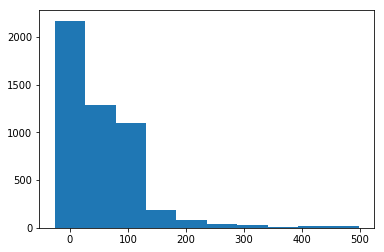

In [76]:
import matplotlib.pyplot as plt

plt.hist(predictions[predictions < 500])

(array([ 3.,  0.,  0.,  0.,  1.,  0.,  2., 21., 51., 90.]),
 array([0.   , 0.999, 1.998, 2.997, 3.996, 4.995, 5.994, 6.993, 7.992,
        8.991, 9.99 ]),
 <a list of 10 Patch objects>)

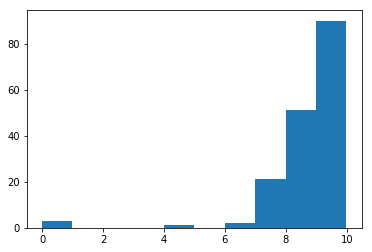

In [82]:
plt.hist(y_test[y_test < 10])

## Predict prices on fake wines

In [91]:
df_fake_wines = pd.read_csv('data/outputs/DESC_v1_2.csv',
                            sep='|',
                            low_memory=False)
df_fake_wines.shape

(1275, 2)

In [103]:
encoded_seq = t.texts_to_sequences(df_fake_wines['description'])
print("Total length: ", len(encoded_seq))
print("Lrngth of first sequence: ", len(encoded_seq[0]))
print("Sample: ", encoded_seq[0][:10])
print("Max value: ",np.max(encoded_seq))

# pad sequences
max_length = max([len(s) for s in encoded_seq])
fake_X = pad_sequences(encoded_seq, maxlen=297, padding='post')

Total length:  1275
Lrngth of first sequence:  62
Sample:  [4, 341, 6, 165, 44, 1, 53, 35, 380, 35]
Max value:  [1922, 203, 1103, 79, 164, 10, 9, 385, 101, 640, 326, 2, 308, 316, 238, 1, 79, 1, 9, 141, 157, 1224, 264, 2, 30, 159, 5, 649, 2, 180, 144, 2, 742, 10, 275, 564, 3, 167, 555, 11, 1, 35, 84, 3, 1, 9, 4, 265, 479, 1688, 73, 392, 12, 1, 16, 7, 12, 27, 2, 382, 3, 450, 2, 204, 4, 295, 2, 589, 9, 18, 3, 302, 48, 322, 318, 277, 2, 217, 1, 21, 7, 17, 28, 67, 9]


In [104]:
X_train.shape

(10177, 297)

In [105]:
fake_X.shape

(1275, 297)

(array([357., 523., 199.,  67.,  45.,  19.,   9.,  10.,  12.,   7.]),
 array([  8.106163,  26.71362 ,  45.321075,  63.92853 ,  82.53599 ,
        101.14345 , 119.7509  , 138.35835 , 156.96582 , 175.57327 ,
        194.18073 ], dtype=float32),
 <a list of 10 Patch objects>)

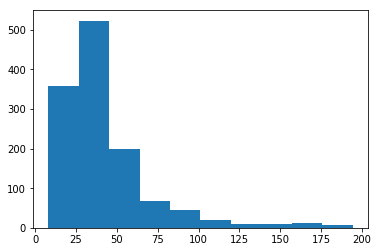

In [108]:
price_predictions = model.predict(fake_X)
plt.hist(price_predictions[price_predictions < 200])

In [113]:
df_fake_wines['price'] = price_predictions.astype(int)
df_fake_wines.to_csv('data/outputs/fakes.csv', sep='|')

In [114]:
df_fake_wines

,name,description,price
0,Joseph Carr Reveliste Cinsault 2013,\n\nRaisage a trip back in time at the Frank F...,44
1,Carol Shelton Roche TBredi 2016,\nAromatics of this wine transporm nine expre...,40
2,Finca Bolgheri Pinot Grigio 2018,"This makes this opened scents, small whitehal...",51
3,Domaine de Cristict Chardonnay 2016,"\nDigest boasts an intensity, or gift W This...",42
4,Domaine Dujac Fils &amp; Pere Chambolle Rouge ...,"On the nose, aromas of grapefruit, lime and a...",40
5,Tenuta Sant'Antonio Barolo Cannubi (1.5 Liter ...,"Being Brisk a town shavings on the east, and ...",94
6,Cavit Alta Luna Pinot Noir 2016,For more than 2000 afters astonishing collabo...,37
7,Philipponnat Royale Reserve 2007,\nBottle is perfect for paired with a hint of...,70
8,Bodegas Lan Culmenet Chardonnay 2017,"\nFor more than a century, has been natisned, ...",35
9,Neil Ellis Groeniel Rose,"Helena, the Santa Maria Valley, the arched th...",119
